In [47]:
#imports
import numpy as np
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import os
from posix import listdir
from random import shuffle
from math import floor
import re
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from numpy.ma.core import argmin
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

%matplotlib inline

In [2]:
#this makes the model deterministic, and thus more repeatable
np.random.seed(0)
torch.manual_seed(0)

In [46]:
path = '/content/drive/MyDrive/ALL_IDB2/img/'         #main directory for training data
dirs = listdir(path)                                  # lists items in training directory
n_p = 8   #number of patches, used both in patchifying and explaining: defined here because the value needs to be same for both

In [48]:
'''
This function makes sure images are correct shape for model, and changes the format to 'tiff'
The function finds all the image files in the training directory, and crops them so that the model can use them
'''
def crop():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imCrop = im.crop((0, 0, 256, 256))
            imCrop.save(f + '.tiff', "TIFF")

In [49]:
'''
This function generates a dataset from the images files in the training folder
It starts by creating a list of all the files of the correct dimensions (with correct extensions)
The label for each object is then found using regular expressions
the label is added to the name in a 2-element list
the list is shuffled and split into training and validation
for each of the two datasets in turn, the filenames are converted into arrays and replaced by these arrays
'''
def data_set_gen():

  #List of files
  dirs = listdir(path)
  data_files = list(filter(lambda file: file.endswith('.tiff'), dirs))

  #Getting labels based on file names
  i = 0
  p = re.compile(r'_1')
  label = [0]*len(data_files)
  while i<len(data_files):
   if (p.findall(data_files[i]) == [str('_1')]):
     label[i] = (1)
   elif (p.findall(data_files[i]) == [str('_0')]):
    label[i] = (0)
   i+=1

  #creating a dataset of labelled filenames
  dataset = [0]*len(data_files)
  i=0
  while i<len(data_files):
   dataset[i] = [data_files[i],label[i]]
   i+=1

  #shuffling and splitting the dataset
  shuffle(dataset)
  split = 0.8
  split_index = floor(len(dataset) * split)
  train_set = dataset[:split_index]
  global test_set
  test_set = dataset[split_index:]

  #replacing the image's names in the training set by the arrays of data which represent them
  global train
  train = [0]*len(train_set)
  i = 0
  while i < len(train_set):
    c = cv2.imread(path+str(train_set[i][0]))
    d = tf.keras.utils.img_to_array(c)
    e = train_set[i][1]
    train[i] = [d,e]
    i+=1

  #replacing the image's names in the training set by the arrays of data which represent them
  global test
  test = [0]*len(test_set)
  i = 0
  while i < len(test_set):
    c = cv2.imread(path+str(test_set[i][0]))
    d = tf.keras.utils.img_to_array(c)
    e = test_set[i][1]
    test[i] = [d,e]
    i+=1

In [88]:
'''
This function trains and validates the model
It starts by loading the data
Next a location for the computations is choosen
Then the model parameters and model itself are defined
The model is then trained
Testing/validation is then performed
'''

def prepare():
    # Loading data
    train_loader = DataLoader(train, shuffle=True)     #loading data sets
    test_loader = DataLoader(test, shuffle=False)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    #choosing processing device
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")  # printing name of device being used

    global model
    model = MyViT((3, 256, 256), n_patches=n_p, n_blocks=4, hidden_d=256, n_heads=2, out_d=2).to(device)     # params
    N_EPOCHS = 100
    LR = 0.0000003

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)    #optimizer, lr = learning rate
    #optimizer = torch.optim.SGD(model.parameters(), lr=LR)       # use this line instead of above line if you want SGD insetad of ADAM
    criterion = CrossEntropyLoss()                                  #loss criterion
    for epoch in trange(N_EPOCHS, desc="Training"):                 #loop for training epoch
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):        #loop for training within epoch
            x, y = batch              #get data, and its label
            y = y.to(device)          #send data to GPU/CPU
            x = x.to(device)
            y_hat = model(x)                           #predicted value of data
            loss = criterion(y_hat, y)                 #loss due to predicted value and exapt value being different

            train_loss += loss.detach().cpu().item() / len(train_loader)  #calculating total loss

            optimizer.zero_grad()                 #optimization of params
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.4f}")    #reporting training accuracy (loss)

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):     # training loop over all data
            x, y = batch                                    # extract data and label
            x, y = x.to(device), y.to(device)               # sending data to be processed
            y_hat = model(x)                                # prediction of model
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()      #increses number of correct if value of y is same as column in output matrix with max probability
            total += len(x)


        print(f"Test loss: {test_loss:.2f}")      #reporting results
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [86]:
'''
This cell contains all of the code for the functions and objects which the ViT model uses, and defines them
'''

'''
Patchify cuts the image into squares for feeding into the transformer
First it makes sure that the image is square
Then it creates a tensor to store the patches
Finally it selects squares from the image, flattens them, and adds them to the tensor it has created
'''
def patchify(images, n_patches):
    n, h, w, c = images.shape

    assert h == w, "Patchify method is implemented for square images only"    #making sure image is square

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)      #creates a tensor to store patches
    patch_size = h // n_patches

    for idx, image in enumerate(images):                  #patchify image
        for i in range(n_patches):                      #horizontal and vertical cuts
            for j in range(n_patches):
                patch = image[i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size,:]   #patchifies by taking pixels in relavent range of h,w
                patches[idx, i * n_patches + j] = patch.flatten()            #turns patch into vector
    return patches



'''
This function adds positional encodings to a new tensor
This means that the model can now know where each patch in original image came from
This is because the value is uniquely dependant on the position of each patch
'''
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)          #creates a tensor with dimensions ,sequence_length, d
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))   #loop writes positional encodings into tensor
    return result

'''
This class defines the operation of a self-attention head
'''
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=4):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        #Dimensions of vector must be divisible between heads so that all heads process equivalent ammounts of data for each image
        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)          #finding the dimension of the input of a head
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)]) #query vector
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)]) #key vector
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)]) #learned vector
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))      #application of self-attention
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])        #combine the outputs of the different heads

'''
This class defines a transformer block
'''
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        #These are defenitions of various attributes and metods of the block
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
    #THis function is what produces the output of the transformer's block, and feeds it forwrd
    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

'''
This class defines the overall operation of the whole model
The various functions which it uses are described where they are defined
'''
class MyViT(nn.Module):
    def __init__(self, hwc, n_patches=n_p, n_blocks=4, hidden_d=256, n_heads=4, out_d=2):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.hwc = hwc # (Height , Width , Colour)
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert hwc[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert hwc[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (hwc[1] / n_patches, hwc[2] / n_patches)

        # 1) Linear mapper for turning matrices into smaller vectors
        self.input_d = int(hwc[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks (makes them part of the model)
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, h, w, c = images.shape   #extracts shapes from image data
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device) #creates patches

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension (hidden_d)
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens (patches)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding so that model know where patch came from
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        #The output of each block is calculated
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out) # Map to output dimension, output category distribution

In [89]:
#crop()
#data_set_gen()
prepare()

Using device:  cpu 


Training:   1%|          | 1/100 [00:31<51:17, 31.09s/it]

Epoch 1/100 loss: 0.7028



Training:   2%|▏         | 2/100 [01:03<51:49, 31.73s/it]

Epoch 2/100 loss: 0.7004



Training:   3%|▎         | 3/100 [01:37<52:54, 32.73s/it]

Epoch 3/100 loss: 0.6990



Training:   4%|▍         | 4/100 [02:09<51:48, 32.38s/it]

Epoch 4/100 loss: 0.6984



Training:   5%|▌         | 5/100 [02:40<50:45, 32.06s/it]

Epoch 5/100 loss: 0.6970



Training:   6%|▌         | 6/100 [03:12<49:58, 31.90s/it]

Epoch 6/100 loss: 0.6966



Training:   7%|▋         | 7/100 [03:45<49:58, 32.25s/it]

Epoch 7/100 loss: 0.6957



Training:   8%|▊         | 8/100 [04:18<49:50, 32.50s/it]

Epoch 8/100 loss: 0.6952



Training:   9%|▉         | 9/100 [04:50<49:11, 32.43s/it]

Epoch 9/100 loss: 0.6945



Training:  10%|█         | 10/100 [05:24<49:26, 32.96s/it]

Epoch 10/100 loss: 0.6930



Training:  11%|█         | 11/100 [05:57<48:51, 32.94s/it]

Epoch 11/100 loss: 0.6926



Training:  12%|█▏        | 12/100 [06:31<48:45, 33.25s/it]

Epoch 12/100 loss: 0.6919



Training:  13%|█▎        | 13/100 [07:04<48:05, 33.17s/it]

Epoch 13/100 loss: 0.6915



Training:  14%|█▍        | 14/100 [07:37<47:24, 33.07s/it]

Epoch 14/100 loss: 0.6904



Training:  15%|█▌        | 15/100 [08:11<47:18, 33.39s/it]

Epoch 15/100 loss: 0.6897



Training:  16%|█▌        | 16/100 [08:45<46:56, 33.52s/it]

Epoch 16/100 loss: 0.6886



Training:  17%|█▋        | 17/100 [09:21<47:33, 34.38s/it]

Epoch 17/100 loss: 0.6882



Training:  18%|█▊        | 18/100 [09:55<46:51, 34.29s/it]

Epoch 18/100 loss: 0.6876



Training:  19%|█▉        | 19/100 [10:29<46:09, 34.19s/it]

Epoch 19/100 loss: 0.6868



Training:  20%|██        | 20/100 [11:04<45:52, 34.41s/it]

Epoch 20/100 loss: 0.6859



Training:  21%|██        | 21/100 [11:38<45:13, 34.35s/it]

Epoch 21/100 loss: 0.6849



Training:  22%|██▏       | 22/100 [12:12<44:31, 34.24s/it]

Epoch 22/100 loss: 0.6844



Training:  23%|██▎       | 23/100 [12:48<44:36, 34.76s/it]

Epoch 23/100 loss: 0.6838



Training:  24%|██▍       | 24/100 [13:22<43:46, 34.56s/it]

Epoch 24/100 loss: 0.6833



Training:  25%|██▌       | 25/100 [13:58<43:39, 34.92s/it]

Epoch 25/100 loss: 0.6825



Training:  26%|██▌       | 26/100 [14:33<42:57, 34.83s/it]

Epoch 26/100 loss: 0.6811



Training:  27%|██▋       | 27/100 [15:07<42:10, 34.66s/it]

Epoch 27/100 loss: 0.6802



Training:  28%|██▊       | 28/100 [15:41<41:31, 34.60s/it]

Epoch 28/100 loss: 0.6800



Training:  29%|██▉       | 29/100 [16:17<41:20, 34.93s/it]

Epoch 29/100 loss: 0.6792



Training:  30%|███       | 30/100 [16:54<41:24, 35.49s/it]

Epoch 30/100 loss: 0.6778



Training:  31%|███       | 31/100 [17:28<40:30, 35.22s/it]

Epoch 31/100 loss: 0.6778



Training:  32%|███▏      | 32/100 [18:04<39:54, 35.21s/it]

Epoch 32/100 loss: 0.6765



Training:  33%|███▎      | 33/100 [18:39<39:30, 35.38s/it]

Epoch 33/100 loss: 0.6765



Training:  34%|███▍      | 34/100 [19:14<38:42, 35.19s/it]

Epoch 34/100 loss: 0.6750



Training:  35%|███▌      | 35/100 [19:49<38:00, 35.08s/it]

Epoch 35/100 loss: 0.6740



Training:  36%|███▌      | 36/100 [20:26<37:58, 35.59s/it]

Epoch 36/100 loss: 0.6729



Training:  37%|███▋      | 37/100 [21:02<37:40, 35.88s/it]

Epoch 37/100 loss: 0.6740



Training:  38%|███▊      | 38/100 [21:37<36:46, 35.60s/it]

Epoch 38/100 loss: 0.6715



Training:  39%|███▉      | 39/100 [22:12<35:59, 35.41s/it]

Epoch 39/100 loss: 0.6704



Training:  40%|████      | 40/100 [22:47<35:18, 35.31s/it]

Epoch 40/100 loss: 0.6693



Training:  41%|████      | 41/100 [23:24<35:10, 35.77s/it]

Epoch 41/100 loss: 0.6693



Training:  42%|████▏     | 42/100 [24:00<34:33, 35.74s/it]

Epoch 42/100 loss: 0.6676



Training:  43%|████▎     | 43/100 [24:37<34:16, 36.07s/it]

Epoch 43/100 loss: 0.6669



Training:  44%|████▍     | 44/100 [25:13<33:43, 36.13s/it]

Epoch 44/100 loss: 0.6659



Training:  45%|████▌     | 45/100 [25:50<33:14, 36.26s/it]

Epoch 45/100 loss: 0.6646



Training:  46%|████▌     | 46/100 [26:26<32:41, 36.32s/it]

Epoch 46/100 loss: 0.6642



Training:  47%|████▋     | 47/100 [27:02<32:01, 36.25s/it]

Epoch 47/100 loss: 0.6622



Training:  48%|████▊     | 48/100 [27:38<31:23, 36.22s/it]

Epoch 48/100 loss: 0.6614



Training:  49%|████▉     | 49/100 [28:17<31:27, 37.00s/it]

Epoch 49/100 loss: 0.6604



Training:  50%|█████     | 50/100 [28:54<30:51, 37.02s/it]

Epoch 50/100 loss: 0.6599



Training:  51%|█████     | 51/100 [29:31<30:05, 36.84s/it]

Epoch 51/100 loss: 0.6579



Training:  52%|█████▏    | 52/100 [30:07<29:21, 36.70s/it]

Epoch 52/100 loss: 0.6571



Training:  53%|█████▎    | 53/100 [30:44<28:50, 36.82s/it]

Epoch 53/100 loss: 0.6558



Training:  54%|█████▍    | 54/100 [31:22<28:23, 37.02s/it]

Epoch 54/100 loss: 0.6547



Training:  55%|█████▌    | 55/100 [32:00<28:01, 37.38s/it]

Epoch 55/100 loss: 0.6535



Training:  56%|█████▌    | 56/100 [32:36<27:15, 37.17s/it]

Epoch 56/100 loss: 0.6526



Training:  57%|█████▋    | 57/100 [33:14<26:42, 37.27s/it]

Epoch 57/100 loss: 0.6514



Training:  58%|█████▊    | 58/100 [33:52<26:15, 37.50s/it]

Epoch 58/100 loss: 0.6496



Training:  59%|█████▉    | 59/100 [34:29<25:33, 37.41s/it]

Epoch 59/100 loss: 0.6484



Training:  60%|██████    | 60/100 [35:07<24:55, 37.40s/it]

Epoch 60/100 loss: 0.6474



Training:  61%|██████    | 61/100 [35:46<24:38, 37.91s/it]

Epoch 61/100 loss: 0.6464



Training:  62%|██████▏   | 62/100 [36:24<24:04, 38.02s/it]

Epoch 62/100 loss: 0.6445



Training:  63%|██████▎   | 63/100 [37:02<23:26, 38.02s/it]

Epoch 63/100 loss: 0.6430



Training:  64%|██████▍   | 64/100 [37:40<22:45, 37.93s/it]

Epoch 64/100 loss: 0.6421



Training:  65%|██████▌   | 65/100 [38:18<22:08, 37.96s/it]

Epoch 65/100 loss: 0.6403



Training:  66%|██████▌   | 66/100 [38:56<21:34, 38.08s/it]

Epoch 66/100 loss: 0.6387



Training:  67%|██████▋   | 67/100 [39:35<21:05, 38.34s/it]

Epoch 67/100 loss: 0.6374



Training:  68%|██████▊   | 68/100 [40:15<20:39, 38.75s/it]

Epoch 68/100 loss: 0.6369



Training:  69%|██████▉   | 69/100 [40:53<19:56, 38.60s/it]

Epoch 69/100 loss: 0.6351



Training:  70%|███████   | 70/100 [41:31<19:13, 38.44s/it]

Epoch 70/100 loss: 0.6327



Training:  71%|███████   | 71/100 [42:10<18:35, 38.48s/it]

Epoch 71/100 loss: 0.6316



Training:  72%|███████▏  | 72/100 [42:49<18:03, 38.69s/it]

Epoch 72/100 loss: 0.6298



Training:  73%|███████▎  | 73/100 [43:28<17:30, 38.91s/it]

Epoch 73/100 loss: 0.6281



Training:  74%|███████▍  | 74/100 [44:08<17:02, 39.32s/it]

Epoch 74/100 loss: 0.6262



Training:  75%|███████▌  | 75/100 [44:47<16:16, 39.07s/it]

Epoch 75/100 loss: 0.6242



Training:  76%|███████▌  | 76/100 [45:26<15:38, 39.09s/it]

Epoch 76/100 loss: 0.6232



Training:  77%|███████▋  | 77/100 [46:06<15:04, 39.31s/it]

Epoch 77/100 loss: 0.6212



Training:  78%|███████▊  | 78/100 [46:46<14:31, 39.63s/it]

Epoch 78/100 loss: 0.6193



Training:  79%|███████▉  | 79/100 [47:26<13:51, 39.58s/it]

Epoch 79/100 loss: 0.6174



Training:  80%|████████  | 80/100 [48:07<13:21, 40.09s/it]

Epoch 80/100 loss: 0.6153



Training:  81%|████████  | 81/100 [48:47<12:40, 40.04s/it]

Epoch 81/100 loss: 0.6136



Training:  82%|████████▏ | 82/100 [49:27<11:58, 39.91s/it]

Epoch 82/100 loss: 0.6121



Training:  83%|████████▎ | 83/100 [50:07<11:20, 40.05s/it]

Epoch 83/100 loss: 0.6106



Training:  84%|████████▍ | 84/100 [50:48<10:45, 40.35s/it]

Epoch 84/100 loss: 0.6082



Training:  85%|████████▌ | 85/100 [51:29<10:06, 40.43s/it]

Epoch 85/100 loss: 0.6066



Training:  86%|████████▌ | 86/100 [52:10<09:31, 40.84s/it]

Epoch 86/100 loss: 0.6042



Training:  87%|████████▋ | 87/100 [52:52<08:52, 40.94s/it]

Epoch 87/100 loss: 0.6028



Training:  88%|████████▊ | 88/100 [53:32<08:10, 40.85s/it]

Epoch 88/100 loss: 0.6007



Training:  89%|████████▉ | 89/100 [54:18<07:47, 42.47s/it]

Epoch 89/100 loss: 0.5987



Training:  90%|█████████ | 90/100 [54:59<06:58, 41.83s/it]

Epoch 90/100 loss: 0.5971



Training:  91%|█████████ | 91/100 [55:41<06:16, 41.88s/it]

Epoch 91/100 loss: 0.5959



Training:  92%|█████████▏| 92/100 [56:23<05:36, 42.01s/it]

Epoch 92/100 loss: 0.5935



Training:  93%|█████████▎| 93/100 [57:04<04:51, 41.65s/it]

Epoch 93/100 loss: 0.5925



Training:  94%|█████████▍| 94/100 [57:44<04:07, 41.30s/it]

Epoch 94/100 loss: 0.5902



Training:  95%|█████████▌| 95/100 [58:25<03:25, 41.12s/it]

Epoch 95/100 loss: 0.5886



Training:  96%|█████████▌| 96/100 [59:06<02:44, 41.15s/it]

Epoch 96/100 loss: 0.5866



Training:  97%|█████████▋| 97/100 [59:48<02:03, 41.28s/it]

Epoch 97/100 loss: 0.5847



Training:  98%|█████████▊| 98/100 [1:00:31<01:23, 41.69s/it]

Epoch 98/100 loss: 0.5835



Training:  99%|█████████▉| 99/100 [1:01:12<00:41, 41.53s/it]

Epoch 99/100 loss: 0.5825



Training: 100%|██████████| 100/100 [1:01:53<00:00, 37.14s/it]


Epoch 100/100 loss: 0.5800


Testing: 100%|██████████| 52/52 [00:03<00:00, 13.99it/s]

Test loss: 0.59
Test accuracy: 71.15%


In [82]:
'''
This function is for using the model, once it has been trained, on new data sets
It starts by listing the files in the relevant directory 'use_path'
This function then turns the list of files into a dataset using a process detailed in documentation for 'data_set_gen'
The model is then used to predict whether the image is ALL or healthy [0 is healthy, 1 is ALL]
If the data has been labelled, the results will be classified
Then the number of correctly-identified images will be shown, as will the number and type of incorrrect attributions
'''
def use():
    # Loading data
    use_path = '/content/drive/MyDrive/39/'
    all_files = os.listdir(os.path.abspath(use_path))    #get list of files to process
    data_files = list(filter(lambda file: file.endswith('.jpg'), all_files))   #chooses correct file format
    size_use = int(len(data_files))

    # creating data set
    datasets_use = [0]*size_use
    j = 0
    while j < size_use:
     a = str(data_files[j])
     b = cv2.imread(use_path+a)
     c = cv2.resize(b, (256,256), interpolation = cv2.INTER_CUBIC)
     datasets_use[j] = [tf.keras.utils.img_to_array(c), a]
     j+=1                                                               #this loop turns the image into an array, adds its name as a label, and adds this object to the data set

    test_loader = DataLoader(datasets_use)

    Correct = 0    # initiating counter variables
    FP = 0
    FN = 0
    p = re.compile(r'_1')   #for use with regex

    #this loop uses the model and can test it on a folder of labelled or unlabelled data
    with torch.no_grad():
        for batch in test_loader:
            x,y_1 = batch
            v = model(x)
            pred = int(torch.argmax(v))
            print(y_1[0], v)

            #this classifies data which has been labelled
            if (p.findall(str(y_1)) == [str('_1')]):
               h = 1
            elif (p.findall(str(y_1)) != [str('_1')]):
              h = 0
            if h == pred:
              Correct+=1
            elif h == 1 and pred == 0:
              FN += 1
            elif h == 0 and pred == 1:
              FP += 1

    if Correct > 0:           #checking that dadat has been labelled
     print(f'Correct = {Correct}')                #showing results if datra has been labelled
     print(f'False Negative = {FN}')
     print(f'False Positive = {FP}')


In [83]:
use()

I_6058.jpg tensor([[0.6007, 0.3993]])
I_6056.jpg tensor([[0.6418, 0.3582]])
I_6059.jpg tensor([[0.6065, 0.3935]])
I_6057.jpg tensor([[0.6234, 0.3766]])
I_6055.jpg tensor([[0.6383, 0.3617]])
I_6052.jpg tensor([[0.6196, 0.3804]])
I_6054.jpg tensor([[0.6270, 0.3730]])
I_6050.jpg tensor([[0.5589, 0.4411]])
I_6053.jpg tensor([[0.6351, 0.3649]])
I_6051.jpg tensor([[0.5749, 0.4251]])
I_6047.jpg tensor([[0.5921, 0.4079]])
I_6049.jpg tensor([[0.5794, 0.4206]])
I_6046.jpg tensor([[0.5973, 0.4027]])
I_6048.jpg tensor([[0.6022, 0.3978]])
I_6045.jpg tensor([[0.6179, 0.3821]])
I_6043.jpg tensor([[0.5820, 0.4180]])
I_6039.jpg tensor([[0.6720, 0.3280]])
I_6038.jpg tensor([[0.6518, 0.3482]])
I_6040.jpg tensor([[0.6409, 0.3591]])
I_6044.jpg tensor([[0.6008, 0.3992]])
I_6041.jpg tensor([[0.6194, 0.3806]])
I_6037.jpg tensor([[0.6474, 0.3526]])
I_6035.jpg tensor([[0.6736, 0.3264]])
I_6036.jpg tensor([[0.6525, 0.3475]])
I_6042.jpg tensor([[0.7166, 0.2834]])
I_6034.jpg tensor([[0.6549, 0.3451]])
I_6095.jpg t

In [11]:
'''
This function tries to explain the model's output using oclusion.
This is a peturbation based aproach where square patches of the image are replaced by zeroes
and the difference between the output for this image and the old image is computed and plotted
The 'explain_path' is the source for the data, and all the files in this folder are listed
A data set where each image is represented as a tensor and labelled by its name is then generated
For each element in the data set, the model is used to predict whether cancer is present
Occulsion is implemented and patches of the image are zeroed; the whole image is covered
The diiferences are put into an array with the same dimensions as the input image
The array is normalised so that its values are between 0. and 1.
The array is plotted as a cmap
'''
def explain():
    #get list of files
    explain_path = '/content/drive/MyDrive/ALL_IDB2/img/'
    all_files = os.listdir(os.path.abspath(explain_path))    #get list of files to process
    data_files = list(filter(lambda file: file.endswith('.tiff'), all_files))
    size_explain = int(len(data_files))

    #get dataset
    datasets_use = [0]*size_explain
    j = 0
    while j < size_explain:
     a = str(data_files[j])
     b = cv2.imread(explain_path+str(data_files[j]))
     datasets_use[j] = [tf.keras.utils.img_to_array(b), a]
     j+=1

    explain_loader = DataLoader(datasets_use, shuffle = True)


    with torch.no_grad():
        for batch in explain_loader:
            x,y_1 = batch                          #get model prediction
            v = model(x)
            pred = int(torch.argmax(v))
            print(y_1[0],';', v)

            i = 0
            global attr
            attr = np.array([[0]*256]*256)
            while i < n_p:                      #horizontal and vertical cuts
             j = 0
             while j < n_p:
              q = np.array(x)

              for k in range(int(256/n_p)):                                #turning the relevant patch into a set of zeroes
                for l in range(int(256/n_p)):
                 q[0][int(i*256/n_p) + k][int(j*256/n_p) + l][:] = 0

              r = torch.from_numpy(q)
              s = model(r)
              diff = float(v[0][1])-float(s[0][1])                      #calculating the resulting change in the model

              for k in range(int(256/n_p)):
                for l in range(int(256/n_p)):
                 attr[int(i*256/n_p) + k][int(j*256/n_p) + l] = diff*10**9      #putting these attributions of regions into an array
              j+=1
             i+=1

            Max = float(np.max(np.array(attr)))
            Min = float(np.min(np.array(attr)))
            attr_1 = (np.array(attr) - Min)/(Max - Min)                   #normalising the array

            plt.imshow(attr_1, cmap='Greys')
            plt.colorbar()
            plt.show()


Im156_0.tiff ; tensor([[0.5057, 0.4943]])


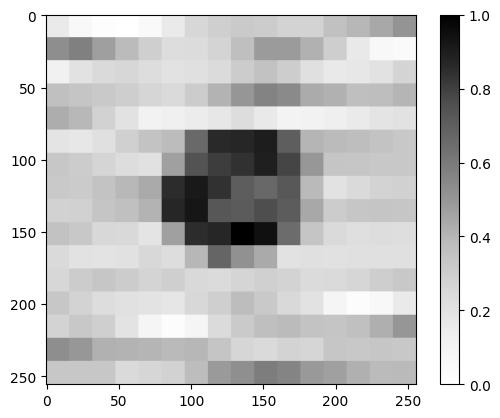

Im060_1.tiff ; tensor([[0.4378, 0.5622]])


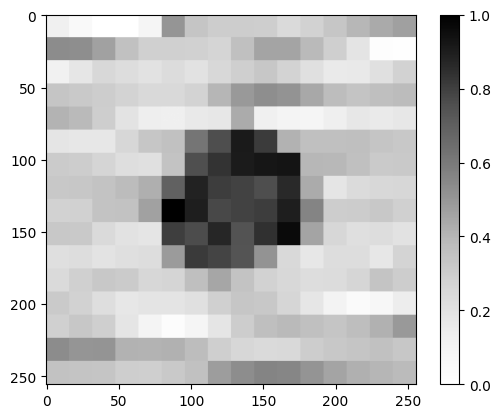

Im211_0.tiff ; tensor([[0.6005, 0.3995]])


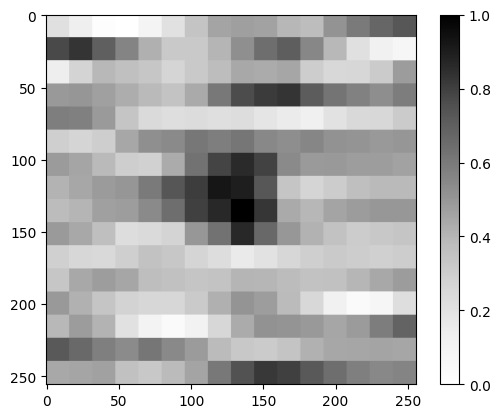

Im108_1.tiff ; tensor([[0.5409, 0.4591]])


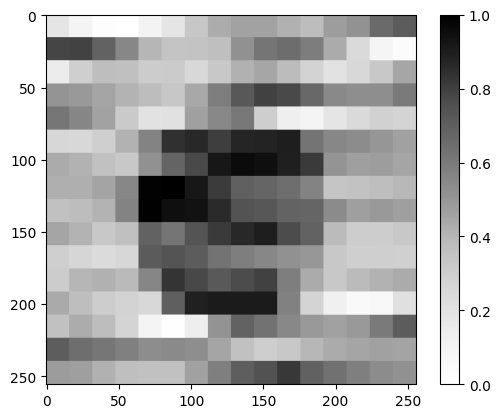

Im168_0.tiff ; tensor([[0.4999, 0.5001]])


KeyboardInterrupt: ignored

In [ ]:
explain()

In [10]:
   '''
   This cell contains code designed to mask the image, but it still has bugs and doesn' work
   '''
   '''
            attr_2 = [[[0]*256]*256]*3
            i = 0
            im = np.array(cv2.imread(str(explain_path+y_1[0])))
            while i < 3:
             for k in range(256):
               for j in range(256):
                attr_2[i][j][k] = attr_1[k][j] * im[j][k][i]                        #creating another array so that data can be masked
             i+=1

            im = Image.open(str(explain_path+y_1[0]))
            im = im.convert('RGB')
            r, g, b = im.split()
            r_0 = np.array(np.array(r)*np.array(attr_1))
            b_0 = np.array(np.array(b)*np.array(attr_1))
            g_0 = np.array(np.array(g)*np.array(attr_1))

            image = [[[0]*3]*256]*256
            i = 0
            while i < 256:
              j = 0
              while j < 256:
                image[i][j] = r_0[i][j], g_0[i][j], b_0[i][j]
                j+=1
              i+=1
            print(image)
            out = Image.fromarray(np.array(image))
            plt.imshow(out)
            plt.show()
            out.show()

            b_1 = Image.fromarray(b_0, 'RGB')
            g_1 = Image.fromarray(g_0, 'RGB')
            g_3 = tf.keras.utils.img_to_array(g_1)

            r_2, d, e = r_1.split()
            g_2, d, e = g_1.split()
            b_2, d, e = b_1.split()
            out = Image.merge('RGB', (r_2, g_2, b_2))
            plt.imshow(out)
            plt.show()
            #out.show()

            Max_1 = float(np.max(np.array(attr_2)))
            Min_1 = float(np.min(np.array(attr_2)))
            attr_3 = (np.array(attr_2) - Min_1)/(Max_1 - Min_1)                  #normalising and plotting the 'masked' array
            plt.imshow(np.transpose((attr_3), (1,2,0)))
            plt.show()
            '''

"\n         attr_2 = [[[0]*256]*256]*3\n         i = 0\n         im = np.array(cv2.imread(str(explain_path+y_1[0])))\n         while i < 3:\n          for k in range(256):\n            for j in range(256):\n             attr_2[i][j][k] = attr_1[k][j] * im[j][k][i]                        #creating another array so that data can be masked\n          i+=1\n\n         im = Image.open(str(explain_path+y_1[0]))\n         im = im.convert('RGB')\n         r, g, b = im.split()\n         r_0 = np.array(np.array(r)*np.array(attr_1))\n         b_0 = np.array(np.array(b)*np.array(attr_1))\n         g_0 = np.array(np.array(g)*np.array(attr_1))\n\n         image = [[[0]*3]*256]*256\n         i = 0\n         while i < 256:\n           j = 0\n           while j < 256:\n             image[i][j] = r_0[i][j], g_0[i][j], b_0[i][j]\n             j+=1\n           i+=1\n         print(image)\n         out = Image.fromarray(np.array(image))\n         plt.imshow(out)\n         plt.show()\n         out.show()\n\